The purpose of this notebook is to build sklearn-like pipeline for transformation

In [2]:
import pandas as pd         
import os.path

N_JOBS = 7

In [3]:
def load_data(path="../../data/csv/all_v2.csv"):
    dataframe = pd.read_csv(path, index_col=0)
    return dataframe.loc[~dataframe["execTimeMs"].isnull()]

In [4]:
def prepare_dataframe(dataframe):
    output = dataframe.dropna(axis="columns")
    targets = output["execTimeMs"]
    dropped = output[["command", "execTimeMs", "jobId", "ctime_mean", "ctime_max", "ctime_sum", "read_sum","write_sum","readSyscalls_sum","writeSyscalls_sum","readReal_sum","writeReal_sum","writeCancelled_sum","rxBytes_sum","rxPackets_sum","rxErrors_sum","rxDrop_sum","rxFifo_sum","rxFrame_sum","rxCompressed_sum","rxMulticast_sum","txBytes_sum","txPackets_sum","txErrors_sum","txDrop_sum","txFifo_sum","txColls_sum","txCarrier_sum","txCompressed_sum","cpu_mean","cpu_max","memory_mean","memory_max"]]
    features = output.drop(dropped.columns, axis=1)
    return features, targets, dropped

In [5]:
features, targets, dropped = prepare_dataframe(load_data())

In [6]:
features.dtypes

workflowName              object
size                     float64
executable                object
args                      object
inputs                    object
outputs                   object
name                      object
cpu.manufacturer          object
cpu.brand                 object
cpu.speed                float64
cpu.cores                  int64
cpu.physicalCores          int64
cpu.processors             int64
mem.total                  int64
mem.free                   int64
mem.used                   int64
mem.active                 int64
mem.available              int64
mem.buffers                int64
mem.cached                 int64
mem.slab                   int64
mem.buffcache              int64
mem.swaptotal              int64
mem.swapused               int64
mem.swapfree               int64
total_cpus               float64
avg_cpus                 float64
avg_pods                 float64
total_ram_available        int64
average_ram_available    float64
dtype: obj

# Preprocessing flow

In [7]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector

In [8]:
def vectorize_list(series):
    def vectorize(list_string):
        return len(eval(list_string))
    return np.vectorize(vectorize)(series)

def ListTransformer():
    return FunctionTransformer(func=vectorize_list)

In [9]:
list_transformer = Pipeline(steps=[("list", ListTransformer()), ("scaler", StandardScaler())])
list_features = list(['args', 'inputs', 'outputs'])

numerical_transformer = StandardScaler()
numerical_features = list(features.select_dtypes(include="number").columns)

categorical_transformer = OneHotEncoder(sparse=False, handle_unknown = "ignore")
categorical_features = list(set(features.select_dtypes(include="object").columns) ^ set(list_features))

def make_classifying_preprocessor(additional_features=["read_sum", "write_sum", "cpu_mean", "memory_max"]):
    external_features = categorical_features + additional_features
    return ColumnTransformer(
            transformers=[('lists', list_transformer, list_features), 
                          ('num', numerical_transformer, numerical_features),
                          ('cat', categorical_transformer, external_features)])

def make_regression_preprocessor(additional_features=["read_sum", "write_sum", "cpu_mean", "memory_max"]):
    external_features = numerical_features + additional_features
    return ColumnTransformer(
        transformers=[
            ('lists', list_transformer, list_features),            
            ('num', numerical_transformer, external_features),  
            ('cat', categorical_transformer, categorical_features)
        ])

preprocessor = make_classifying_preprocessor(additional_features=[])

In [10]:
from scipy.stats import percentileofscore
import math

def calculate_quantile_rank(labels, label):
    return percentileofscore(labels, label) / 100

def calculate_utilization_class(labels, label):
    def label_for_rank(rank):
        if rank > 0.75:
            return 'very high'
        elif rank > 0.5:
            return 'high'
        elif rank > 0.25:
            return 'medium'
        else:
            return 'low'
    return label_for_rank(calculate_quantile_rank(labels, label))

def calculate_utilization_bucket(labels, label, num_buckets):
    bucket_size = 1.0 / num_buckets
    def bucket_for_rank(rank):
        return str(math.floor(rank / bucket_size))
    return bucket_for_rank(calculate_quantile_rank(labels, label))

# Pipeline composition (with PCA)

In [11]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import Lasso, SGDRegressor, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV

In [12]:
base_steps = [('pca', PCA(random_state=42))]
dummy_pipeline = Pipeline(steps=base_steps +[('dummy', DummyRegressor())])
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=0)

In [13]:
pca_param_grid = {
    'pca__n_components': np.arange(1, 50, 3),    
}
knn_param_grid = {
    'knn__n_neighbors': np.arange(1, 30, 3),
}
regressor = ('knn', KNeighborsRegressor())
full_pipeline = Pipeline(steps= base_steps + [regressor])
grid_search = HalvingGridSearchCV(full_pipeline, {**knn_param_grid, **pca_param_grid}, cv=2, verbose=2, scoring="r2", n_jobs=-1)

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from loky import get_reusable_executor

def rate_regressor(X_train, y_train, X_test, y_test, regressor, regressor_params, verbose=10, aggressive_elimination=True, steps=base_steps):
    print(f"Rating {regressor}")
    full_pipeline = Pipeline(steps= base_steps + [regressor])
    vector_length = X_train.shape[1]
    pca_param_grid = {'pca__n_components': np.arange(1, vector_length, 1),}
    grid_search = HalvingGridSearchCV(full_pipeline, {**pca_param_grid, **regressor_params}, cv=2, verbose=verbose, scoring="r2", n_jobs=N_JOBS)
    print("Evaluating grid search")
    grid_search.fit(X_train, y_train)
    
    # scores
    print("Predicting on test set")
    prediction = grid_search.best_estimator_.predict(X_test)
    
    print("Calculating scores")
    executor = get_reusable_executor(max_workers=3, timeout=5)
    
    scores = [lambda true, pred: r2_score(true, pred), lambda true, pred: mean_absolute_error(true, pred), lambda true, pred: mean_absolute_percentage_error(true, pred)]
    results = executor.map(lambda fun: fun(y_test, prediction), scores)
    print("Calculated scores on test set")
    r2, mae, mape = list(results)
    adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    return {"r2": r2, "adjusted_r2": adjusted_r2, "mae": mae, "mape": mape,"best_score": grid_search.best_score_, "params": grid_search.best_params_}

In [15]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score

def rate_classifier(X_train, y_train, X_test, y_test, classifier, classifier_params, verbose=10, aggressive_elimination=True, steps=base_steps):
    print(f"Rating {classifier}")
    full_pipeline = Pipeline(steps= base_steps + [classifier])
    vector_length = X_train.shape[1]
    pca_param_grid = {'pca__n_components': np.arange(1, vector_length, 1),}
    grid_search = HalvingGridSearchCV(full_pipeline, {**pca_param_grid, **classifier_params}, cv=2, verbose=verbose, scoring="accuracy", n_jobs=N_JOBS)
    print("Evaluating grid search")
    grid_search.fit(X_train, y_train)
    
    # scores
    print("Predicting on test set")
    prediction = grid_search.best_estimator_.predict(X_test)
    
    print("Calculating scores")
    executor = get_reusable_executor(max_workers=5, timeout=5)
    
    scores = [
        lambda true, pred: f1_score(true, pred, average="micro"),
        lambda true, pred: f1_score(true, pred, average="macro"),
        lambda true, pred: accuracy_score(true, pred), 
        lambda true, pred: balanced_accuracy_score(true, pred)
    ]
    results = executor.map(lambda fun: fun(y_test, prediction), scores)
    print("Calculated scores on test set")
    micro, macro, accuracy, balanced_accuracy = list(results)
    return {"f1_micro": micro, "f1_macro": macro, "accuracy": accuracy, "balanced_accuracy": balanced_accuracy, "params": grid_search.best_params_}

# Here go regressor params

In [16]:
knn = ("knn", KNeighborsRegressor())
knn_params = {'knn__n_neighbors': np.arange(1, 30, 1)}

lasso = ("lasso", Lasso(random_state=5))
lasso_params = {"lasso__alpha": np.arange(0.01, 1, 0.05)}

mlp_regressor = ("mlp", MLPRegressor(random_state=5))
mlp_params = {"mlp__activation": ["relu", "logistic"], "mlp__hidden_layer_sizes": [(100,), (100, 50,)]}

dtr = ("dtr", DecisionTreeRegressor(random_state=5))
dtr_params = {"dtr__criterion": ["mse", "friedman_mse", "mae", "poisson"], "dtr__max_depth": [5, 10, 15, 25]}

en = ("elasticnet", ElasticNet(random_state=5))
en_params = {"elasticnet__alpha": np.arange(0.01, 1, 0.05), "elasticnet__l1_ratio": np.arange(0, 1, 0.1)}

svr = ("svr", SGDRegressor())
svr_params = {"svr__loss": ["squared_loss", "huber", "epsilon_insensitive"], "svr__penalty": ['l2', 'l1', 'elasticnet'],
             "svr__alpha": np.arange(0.0001, 0.2, 0.01), "svr__max_iter": [10000]}

# Here go classifier params

In [17]:
knn_classifier = ("knn", KNeighborsClassifier())
knn_clf_params = {'knn__n_neighbors': np.arange(1, 30, 1)}

dtr_classifier = ("dtr", DecisionTreeClassifier(random_state=5))
dtr_clf_params = {"dtr__criterion": ["gini", "entropy"]}

mlp_classifier = ("mlp", MLPClassifier())
mlp_clf_params = {"mlp__hidden_layer_sizes": np.arange(1,200, 10),          
                  "mlp__activation": ["logistic", "tanh", "relu"],         
                  "mlp__activation": ["logistic"],         
#                   "mlp__alpha": np.arange(0.01, 0.1, 0.01)
                 }

svc = ("svc", SVC(random_state=5))
svc_clf_params = {
    "svc__C": np.arange(0.1, 1, 0.1), 
    "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svc__degree": np.arange(3, 10, 1)
}

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
def make_datasets(dataframe):
    jobs_below_1200ms = dataframe.loc[dataframe["execTimeMs"] < 1200]
    jobs_between_2000ms_25000ms = dataframe.loc[dataframe["execTimeMs"].between(2000, 25000)]
    jobs_count = dataframe["name"].value_counts()
    jobs_most_occuring = dataframe.loc[dataframe["name"].isin(jobs_count[jobs_count > 3000].index.values)]
    jobs_mDiffFit = dataframe.loc[dataframe["name"] == "mDiffFit"]
    jobs_haplotype = dataframe.loc[dataframe["name"] == "haplotype_caller"]
    jobs_mShrink = dataframe.loc[dataframe["name"] == "mShrink"]
    return jobs_below_1200ms, jobs_between_2000ms_25000ms, jobs_most_occuring

In [20]:
datasets = make_datasets(load_data())

In [21]:
dfs_for_jobs = [pd.DataFrame(y) for x, y in load_data().groupby('name', as_index=False)]

In [22]:
def rate_data(features, targets, regressors, verbose=10, pipeline_steps=base_steps):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)
    df = pd.DataFrame(columns=["name", "pca", "adjusted_r2","r2", "mae", "mape", "best_score", "params"])
    for (regressor, params) in regressors:
        result = rate_regressor(X_train, y_train, X_test, y_test, regressor, params, verbose, pipeline_steps)
        df = df.append({"name": regressor[0], **result, "pca": result["params"]["pca__n_components"]}, ignore_index=True)
    return df

In [23]:
def rate_classifiers_for_data(features, targets, classifiers, verbose=10, pipeline_steps=base_steps):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)
    df = pd.DataFrame(columns=["name", "pca", "accuracy","balanced_accuracy", "f1_micro", "f1_macro", "params"])
    for (classifier, params) in classifiers:
        result = rate_classifier(X_train, y_train, X_test, y_test, classifier, params, verbose, pipeline_steps)
        df = df.append({"name": classifier[0], **result, "pca": result["params"]["pca__n_components"]}, ignore_index=True)
    return df

In [24]:
def rate_dataset(dataframe, regressors, verbose=2):
    print(f"Rating dataset of len {len(dataframe)}")
    features, targets, _ = prepare_dataframe(dataframe[:10000])
    features = preprocessor.fit_transform(features)
    rate_data(features, targets, regressors, verbose)

In [25]:
basic_regressors = [
    (knn, knn_params),
    (dtr, dtr_params),
    (lasso, lasso_params),
    (mlp_regressor, mlp_params),
    (en, en_params),
    (svr, svr_params),
]

basic_classifiers = [
    (knn_classifier, knn_clf_params),
#     (dtr_classifier, dtr_clf_params),
    (mlp_classifier, mlp_clf_params),
    (svc, svc_clf_params)
]

In [26]:
def simple_experiment():
    print("Rating jobs datasets")
    for dataset in dfs_for_jobs:
        print(dataset.iloc[0]["name"])
        rate_dataset(dataset, basic_regressors)

    print("Rating common datasets")
    for dataset in datasets:
        rate_dataset(dataset, basic_regressors)

In [27]:
# rate_dataset(dfs_for_jobs[8], verbose=0)
# rate_dataset(dfs_for_jobs[1], basic_regressors, verbose=0)

## Eksperyment 1

### Cel

Dowiedzieć się jakiego pipelinu użyć do predykcji czasu obliczeń

### Dane 
krótsze niż 1200ms, 2k-25k ms, częstsze niż 3000, wszystkie

In [28]:
raw_dataframe = load_data()
jobs_count = raw_dataframe["name"].value_counts()
exp1_datasets = {
    "ShorterThan1.2Kms": raw_dataframe.loc[raw_dataframe["execTimeMs"] < 1200],
    "Between2KmsAnd25Kms": raw_dataframe.loc[raw_dataframe["execTimeMs"].between(2000, 25000)],
    "ExecutedMoreThan3Ktimes": raw_dataframe.loc[raw_dataframe["name"].isin(jobs_count[jobs_count > 3000].index.values)],
    "All": raw_dataframe
}

def get_categorical_pipeline_data(data, resources=[], num_buckets=4):
    """
    Raw data enhanced with resource utilization classes, but classes are assigned - not predicted
    """
    features, labels, dropped = prepare_dataframe(data)
    for resource in resources:
        features[resource] = dropped[resource].map(lambda value: calculate_utilization_bucket(dropped[resource], value, num_buckets))
    features = make_classifying_preprocessor(resources).fit_transform(features)
    return features, labels

def get_numerical_pipeline_data(data, resources=["read_sum", "write_sum", "cpu_mean", "memory_max"]):
    """
    Raw data enhanced with resource utilization quantile scores, but scores are assigned - not predicted
    """
    features, labels, dropped = prepare_dataframe(data)
    for resource in resources:
        features[resource] = dropped[resource].map(lambda value: calculate_quantile_rank(dropped[resource], value))
    features = make_regression_preprocessor(resources).fit_transform(features)
    return features, labels

### Przebieg
dla każdego zbioru sprawdzamy, który pipeline jest lepszy i w jakim wariancie

In [37]:
import seaborn as sns

In [38]:
def run_experiment1a():
    exp1a_resources = ["read_sum", "write_sum", "cpu_mean", "memory_mean"]
    
    full_df = pd.DataFrame(columns=["dataset", "pipeline", "name", "pca", "adjusted_r2","r2", "mae", "mape", "best_score", "params"])
    for name, dataset in exp1_datasets.items():
        print(f"Evaluating dataset {name} of length {len(dataset)}")
        def run_pipeline(name, features, targets):
            pipeline_df = rate_data(features, targets, basic_regressors, verbose=10)
            pipeline_df["pipeline"] = name
            return pipeline_df
        dataset_df = pd.concat([
            run_pipeline("simple", *get_categorical_pipeline_data(dataset)),
            run_pipeline("two_step_4_cat", *get_categorical_pipeline_data(dataset, resources=exp1a_resources)),
            run_pipeline("two_step_continuous", *get_numerical_pipeline_data(dataset, resources=exp1a_resources)),
            run_pipeline("two_step_5_cat", *get_categorical_pipeline_data(dataset, exp1a_resources, 5)),
            run_pipeline("two_step_6_cat", *get_categorical_pipeline_data(dataset, exp1a_resources, 6)),
            run_pipeline("two_step_7_cat", *get_categorical_pipeline_data(dataset, exp1a_resources, 7)),
            run_pipeline("two_step_8_cat", *get_categorical_pipeline_data(dataset, exp1a_resources, 8)),
            run_pipeline("two_step_9_cat", *get_categorical_pipeline_data(dataset, exp1a_resources, 9)),
            run_pipeline("two_step_10_cat", *get_categorical_pipeline_data(dataset, exp1a_resources, 10)),
        ])
        dataset_df["dataset"] = name
        full_df = full_df.append(dataset_df)
    return full_df

def run_experiment1b():
    exp1b_resources = ["read_sum", "write_sum", "cpu_max", "cpu_mean", "memory_mean", "memory_max"]
    
    full_df = pd.DataFrame(columns=["dataset", "pipeline", "name", "pca", "adjusted_r2","r2", "mae", "mape", "best_score", "params"])
    for name, dataset in exp1_datasets.items():
        print(f"Evaluating dataset {name} of length {len(dataset)}")
        def run_pipeline(name, features, targets):
            print(f"Running pipeline {name}")
            pipeline_df = rate_data(features, targets, basic_regressors, verbose=0)
            pipeline_df["pipeline"] = name
            return pipeline_df
        dataset_df = pd.concat([
            run_pipeline("continuous_more_res", *get_numerical_pipeline_data(dataset, exp1b_resources)),
            run_pipeline("4cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 4)),
            run_pipeline("5cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 5)),
            run_pipeline("6cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 6)),
            run_pipeline("7cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 7)),
            run_pipeline("8cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 8)),
            run_pipeline("9cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 9)),
            run_pipeline("10cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 10)),
            run_pipeline("11cat_more_res", *get_categorical_pipeline_data(dataset, exp1b_resources, 11))
        ])
        dataset_df["dataset"] = name
        full_df = full_df.append(dataset_df)
    return full_df

In [39]:
if not os.path.isfile("data/exp1.csv"):
    print("Running experiment 1a")
    exp1a_df = run_experiment1a()
    exp1a_df.to_csv("data/exp1.csv")
else:
    exp1a_df = pd.read_csv("data/exp1.csv").round(2)

if not os.path.isfile("data/exp1b.csv"):
    print("Running experiment 1b")
    exp1b_df = run_experiment1b()
    exp1b_df.to_csv("data/exp1b.csv")
else:
    exp1b_df = pd.read_csv("data/exp1b.csv").round(2)

exp1_df = pd.concat([exp1a_df, exp1b_df])

In [40]:
exp1_df = exp1_df.drop("Unnamed: 0", axis=1)

In [41]:
sorted_simple = exp1_df.loc[exp1_df.pipeline == "simple"].sort_values(["dataset", "r2"], ascending=False)
sorted_simple["pipeline"] = "a. Single step"
sorted_simple["name"] = sorted_simple["name"].map(lambda value: f"{value} (a)")

sorted_two_step = exp1_df.loc[(exp1_df.pipeline != "simple") & (exp1_df.name != "lasso") & (exp1_df.name != "elasticnet")].sort_values(["dataset", "r2", "name"], ascending=False)
sorted_two_step["name"] = sorted_two_step["name"].map(lambda value: f"{value} (b)")
sorted_two_step["pipeline"] = "b. Two steps"


In [42]:
sorted_two_step.drop_duplicates(subset=["name"])

,dataset,pipeline,name,pca,adjusted_r2,r2,mae,mape,best_score,params
15,ShorterThan1.2Kms,b. Two steps,mlp (b),55,0.85,0.85,59.17,0.22,0.83,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
12,ShorterThan1.2Kms,b. Two steps,knn (b),41,0.82,0.82,64.49,0.23,0.80,"{'knn__n_neighbors': 5, 'pca__n_components': 41}"
43,ShorterThan1.2Kms,b. Two steps,dtr (b),82,0.79,0.79,71.90,0.28,0.76,"{'dtr__criterion': 'mse', 'dtr__max_depth': 10..."
35,ShorterThan1.2Kms,b. Two steps,svr (b),50,0.75,0.76,84.94,0.34,0.75,"{'pca__n_components': 50, 'svr__alpha': 0.0001..."


In [43]:
dataframes = []
for dataset in exp1_datasets.keys():
    top3_simple = sorted_simple.loc[sorted_simple.dataset == dataset].drop_duplicates(subset=["name"]).head(3)
    top3_two_step = sorted_two_step.loc[sorted_two_step.dataset == dataset].drop_duplicates(subset=["name"]).head(3)
    dataframes.append(top3_simple)
    dataframes.append(top3_two_step)

concat_df = pd.concat(dataframes)

In [44]:
concat_df

,dataset,pipeline,name,pca,adjusted_r2,r2,mae,mape,best_score,params
3,ShorterThan1.2Kms,a. Single step,mlp (a),56,0.68,0.68,89.13,0.37,0.66,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
0,ShorterThan1.2Kms,a. Single step,knn (a),47,0.67,0.67,90.71,0.36,0.65,"{'knn__n_neighbors': 7, 'pca__n_components': 47}"
1,ShorterThan1.2Kms,a. Single step,dtr (a),57,0.59,0.60,109.53,0.51,0.59,"{'dtr__criterion': 'mse', 'dtr__max_depth': 5,..."
15,ShorterThan1.2Kms,b. Two steps,mlp (b),55,0.85,0.85,59.17,0.22,0.83,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
12,ShorterThan1.2Kms,b. Two steps,knn (b),41,0.82,0.82,64.49,0.23,0.80,"{'knn__n_neighbors': 5, 'pca__n_components': 41}"
43,ShorterThan1.2Kms,b. Two steps,dtr (b),82,0.79,0.79,71.90,0.28,0.76,"{'dtr__criterion': 'mse', 'dtr__max_depth': 10..."
54,Between2KmsAnd25Kms,a. Single step,knn (a),55,0.77,0.77,2393.54,0.24,0.75,"{'knn__n_neighbors': 4, 'pca__n_components': 55}"
57,Between2KmsAnd25Kms,a. Single step,mlp (a),43,0.72,0.73,2783.37,0.30,0.70,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
55,Between2KmsAnd25Kms,a. Single step,dtr (a),28,0.68,0.69,3019.08,0.32,0.67,"{'dtr__criterion': 'mse', 'dtr__max_depth': 5,..."
99,Between2KmsAnd25Kms,b. Two steps,mlp (b),109,0.94,0.95,990.14,0.12,0.94,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."


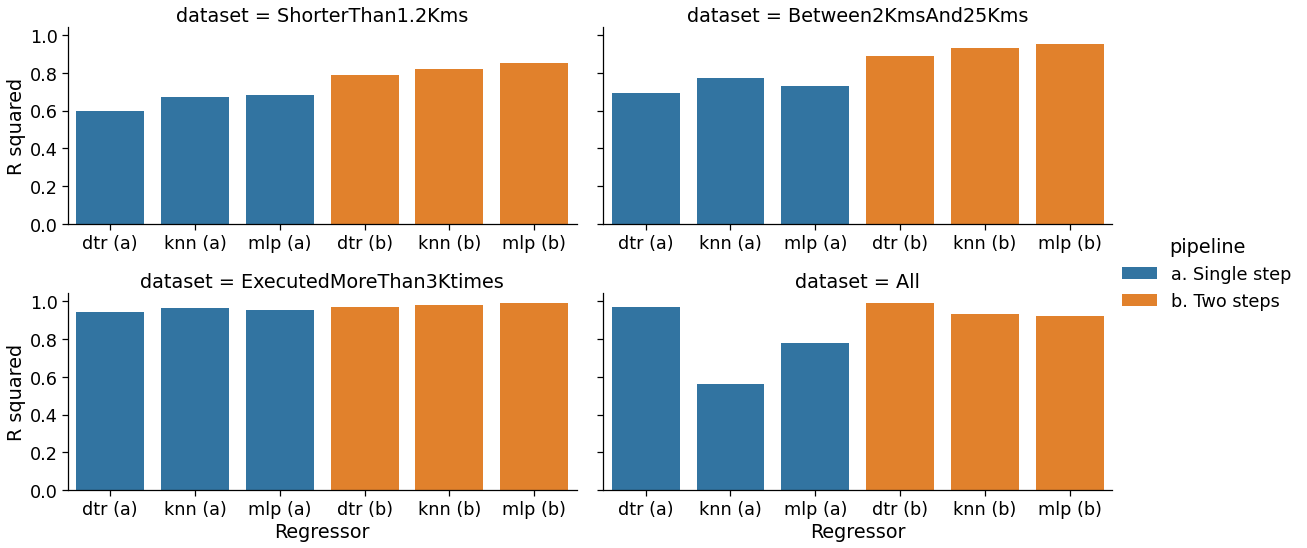

In [45]:
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.FacetGrid(concat_df, col="dataset", hue="pipeline", height=4, aspect=2, col_wrap=2, sharex=False)
    g.map(sns.barplot, "name", "r2",  order=[ "dtr (a)", "knn (a)", "mlp (a)", "dtr (b)", "knn (b)","mlp (b)"], hue_order=["a. Single step", "b. Two steps"])
    g.axes[2].set_xlabel("Regressor")
    g.axes[3].set_xlabel("Regressor")
    g.axes[0].set_ylabel("R squared")
    g.axes[2].set_ylabel("R squared")
    g.add_legend(loc="center right")
    g.savefig("pipelineComparisonRsquared.png")

In [46]:
concat_df.loc[concat_df.dataset == "Between2KmsAnd25Kms"]

,dataset,pipeline,name,pca,adjusted_r2,r2,mae,mape,best_score,params
54,Between2KmsAnd25Kms,a. Single step,knn (a),55,0.77,0.77,2393.54,0.24,0.75,"{'knn__n_neighbors': 4, 'pca__n_components': 55}"
57,Between2KmsAnd25Kms,a. Single step,mlp (a),43,0.72,0.73,2783.37,0.30,0.70,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
55,Between2KmsAnd25Kms,a. Single step,dtr (a),28,0.68,0.69,3019.08,0.32,0.67,"{'dtr__criterion': 'mse', 'dtr__max_depth': 5,..."
99,Between2KmsAnd25Kms,b. Two steps,mlp (b),109,0.94,0.95,990.14,0.12,0.94,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
84,Between2KmsAnd25Kms,b. Two steps,knn (b),81,0.92,0.93,1147.74,0.13,0.91,"{'knn__n_neighbors': 2, 'pca__n_components': 81}"
67,Between2KmsAnd25Kms,b. Two steps,dtr (b),62,0.89,0.89,1340.62,0.15,0.84,"{'dtr__criterion': 'friedman_mse', 'dtr__max_d..."


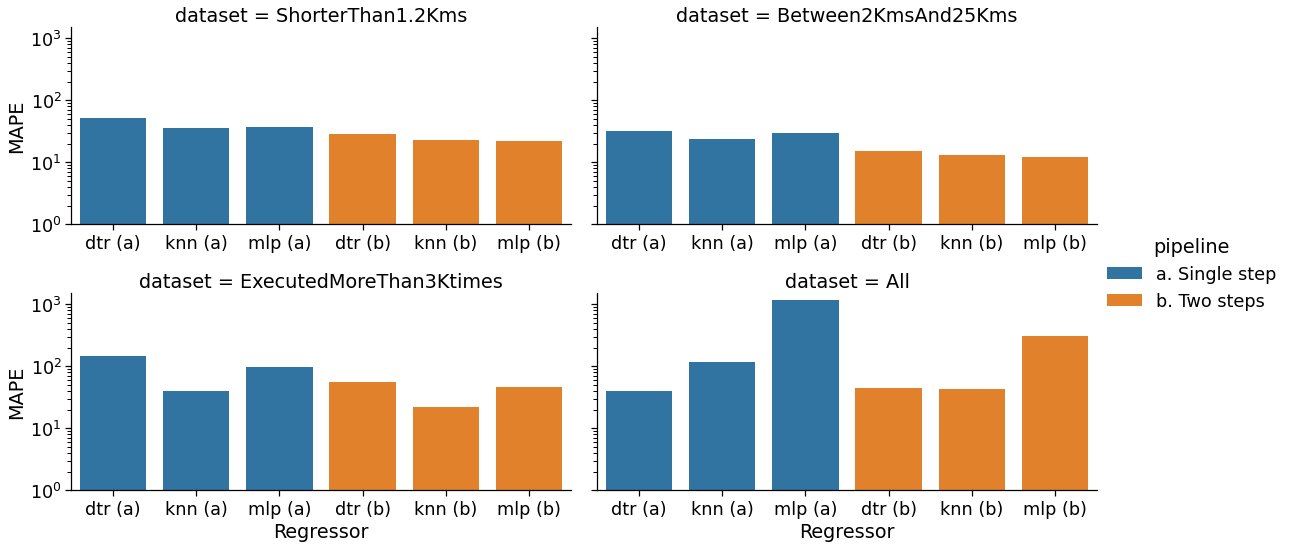

In [47]:
plot_df = concat_df.copy()
plot_df["mape"] = plot_df["mape"].map(lambda value: value * 100)
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.FacetGrid(plot_df, col="dataset", hue="pipeline", height=4, aspect=2, col_wrap=2, sharex=False)
    g.map(sns.barplot, "name", "mape", order=[ "dtr (a)", "knn (a)", "mlp (a)", "dtr (b)", "knn (b)","mlp (b)"], hue_order=["a. Single step", "b. Two steps"]).set(yscale = "log")
#     for i in range(0, 4):
#         g.axes[i].set_yscale("log")
    g.set(ylim=(1, 1500))
    g.axes[2].set_xlabel("Regressor")
    g.axes[3].set_xlabel("Regressor")
    g.axes[0].set_ylabel("MAPE")
    g.axes[2].set_ylabel("MAPE")
    g.add_legend()
    g.savefig("pipelineComparisonMape.png")

In [48]:
sorted_simple = exp1_df.loc[exp1_df.pipeline == "simple"].sort_values(["dataset", "r2"], ascending=False)
sorted_simple["pipeline"] = "Single step"
sorted_simple["name"] = sorted_simple["name"].map(lambda value: f"{value}")

sorted_two_step = exp1_df.loc[(exp1_df.pipeline != "simple") & (exp1_df.name != "lasso") & (exp1_df.name != "elasticnet")].sort_values(["dataset", "r2", "name"], ascending=False)
sorted_two_step["name"] = sorted_two_step["name"].map(lambda value: f"{value}")
sorted_two_step["pipeline"] = "Two steps"
dataframes = []
for dataset in exp1_datasets.keys():
    top3_simple = sorted_simple.loc[sorted_simple.dataset == dataset].drop_duplicates(subset=["name"]).head(3)
    top3_two_step = sorted_two_step.loc[sorted_two_step.dataset == dataset].drop_duplicates(subset=["name"]).head(3)
    dataframes.append(top3_simple)
    dataframes.append(top3_two_step)

concat_df = pd.concat(dataframes)

In [49]:
csv_exp1 = concat_df.drop(["params", "adjusted_r2", "pca", "mae", "best_score"], axis=1)
csv_exp1["name"] = csv_exp1["name"].str.upper()
csv_exp1.to_csv("exp1_concatdf2.csv", index=False)

In [50]:
sorted_two_step = exp1_df.loc[(exp1_df.pipeline != "simple") & (exp1_df.name != "lasso") & (exp1_df.name != "elasticnet")].sort_values(["dataset", "r2", "name"], ascending=False)

In [51]:
pd.set_option('display.max_rows', None)
ds_df = sorted_two_step.loc[sorted_two_step.dataset == "ShorterThan1.2Kms"].drop_duplicates(subset="pipeline")
ds_df = ds_df.loc[ds_df.pipeline.str.contains("more_res")]
values = ds_df.pipeline.values
values = [value.split("_")[0] for value in values]

In [52]:
plot_df.loc[plot_df.dataset == "Between2KMsAnd25KMs"]

,dataset,pipeline,name,pca,adjusted_r2,r2,mae,mape,best_score,params


In [53]:
from collections import OrderedDict

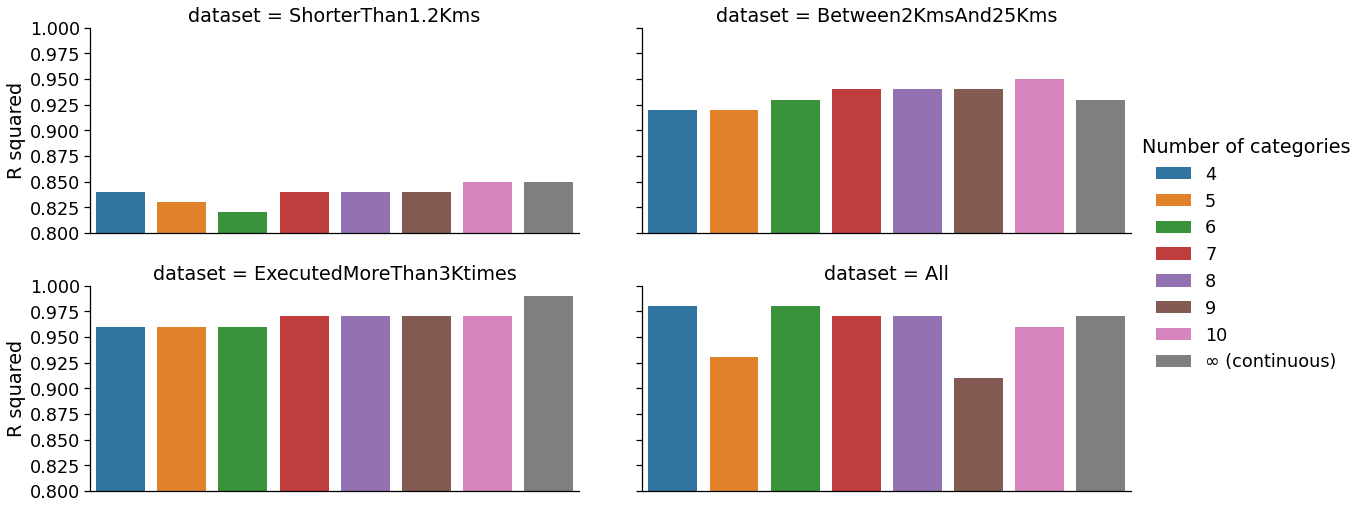

In [54]:
dataframes = []
for dataset in exp1_datasets.keys():
    ds_df = sorted_two_step.loc[sorted_two_step.dataset == dataset].drop_duplicates(subset="pipeline")
    ds_df = ds_df.loc[ds_df.pipeline.str.contains("more_res") & (~ds_df.pipeline.str.contains("11"))]
    dataframes.append(ds_df)

plot_df = pd.concat(dataframes)


categories = OrderedDict({
    "4cat": "4",
    "5cat": "5",
    "6cat": "6",
    "7cat": "7",
    "8cat": "8",
    "9cat": "9",
    "10cat": "10",
    "continuous": "∞ (continuous)"
})


# to prevent reordering
ord_values = [categories[k] for k in categories.keys()]
plot_df.pipeline=plot_df.pipeline.map(lambda value: categories[value.split("_")[0]])
plot_df = plot_df.rename(columns={"pipeline": "Number of categories"})
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.FacetGrid(plot_df, col="dataset", hue="Number of categories", height=4, aspect=2, col_wrap=2, sharey=True, hue_order=ord_values)
    g.map(sns.barplot, "Number of categories", "r2", order=ord_values)
#     for ax in g.axes.flat:
#         for label in ax.get_xticklabels():
#             label.set_rotation(90)
    g.set(ylim=(0.8, 1))
    g.set(xticks=[])
    g.axes[3].set_xlabel("")
    g.axes[2].set_xlabel("")
    g.axes[0].set_ylabel("R squared")
    g.axes[2].set_ylabel("R squared")
    g.add_legend()
    g.savefig("categorisationComparisonRsquared.png")

In [55]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

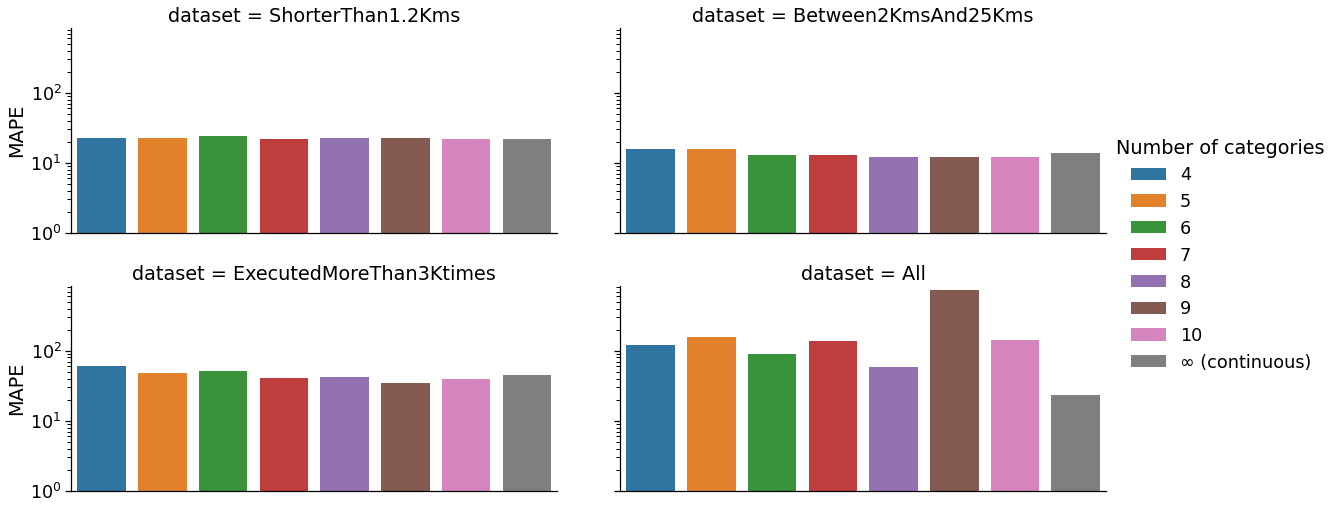

In [56]:
here_plot_df = plot_df.copy()
here_plot_df.mape = here_plot_df.mape * 100
with sns.plotting_context("notebook", font_scale=1.6):
    plt.clf()
    g = sns.FacetGrid(here_plot_df, col="dataset", hue="Number of categories", height=4, aspect=2, col_wrap=2, sharey=True, hue_order=ord_values)
    g.map(sns.barplot, "Number of categories", "mape", order=ord_values).set(yscale="log")
#     for ax in g.axes.flat:
#         for label in ax.get_xticklabels():
#             label.set_rotation(90)
    g.set(ylim=(1, 850))
    g.set(xticks=[])
    g.axes[3].set_xlabel("")
    g.axes[2].set_xlabel("")
    g.axes[0].set_ylabel("MAPE")
    g.axes[2].set_ylabel("MAPE")
    g.add_legend()
    g.savefig("categorisationComparisonMape.png")

In [57]:
here_plot_df.drop(columns=["pca", "adjusted_r2", "mae", "best_score", "params"]).to_csv("exp1b_concat.csv",index=False)

In [61]:
exp1_df.loc[exp1_df.dataset =="All"].sort_values(["r2"], ascending=False).loc[163].iloc[1].params

"{'dtr__criterion': 'mae', 'dtr__max_depth': 15, 'pca__n_components': 78}"

### Output eksperymentu
#### Wykresy

wykresy: R^2, MAE i MAPE dla każdego zbioru i każdego pipeline'u (powiedzmy że dla 3 najlepszych z każdego)

In [36]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 20)})

In [37]:
def bar(data, x, y, hue, order):
    plt = sns.catplot(x=x, y=y, hue=hue, kind="bar", data=data, height=14, aspect=3, hue_order=order, ci=None)
    plt.set(yscale="log")
    return plt

In [38]:
def errors_df(df, err, fun=lambda df: df.idxmin()):
    return df.iloc[fun(df.groupby(["pipeline", "dataset"])[err])]

In [39]:
pipeline_order=["simple","two_step_4_cat","two_step_5_cat","two_step_6_cat","two_step_7_cat","two_step_8_cat","two_step_9_cat","two_step_10_cat", "two_step_continuous", "8cat_more_res", "9cat_more_res", "10cat_more_res", "continuous_more_res"]

In [143]:
errors_df(exp1_df, "mape")

,dataset,pipeline,name,pca,adjusted_r2,r2,mae,mape,best_score,params
204,All,two_step_9_cat,knn,83,0.89,0.89,3442.41,0.35,0.66,"{'knn__n_neighbors': 4, 'pca__n_components': 83}"
96,Between2KmsAnd25Kms,two_step_9_cat,knn,91,0.92,0.92,1122.13,0.13,0.90,"{'knn__n_neighbors': 3, 'pca__n_components': 91}"
150,ExecutedMoreThan3Ktimes,two_step_9_cat,knn,51,0.97,0.97,883.39,0.24,0.97,"{'knn__n_neighbors': 4, 'pca__n_components': 51}"
45,ShorterThan1.2Kms,two_step_9_cat,mlp,82,0.84,0.84,62.00,0.23,0.81,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
211,All,two_step_10_cat,dtr,80,0.98,0.98,2333.48,0.55,0.88,"{'dtr__criterion': 'mae', 'dtr__max_depth': 10..."
...,...,...,...,...,...,...,...,...,...,...
45,ShorterThan1.2Kms,two_step_9_cat,mlp,82,0.84,0.84,62.00,0.23,0.81,"{'mlp__activation': 'relu', 'mlp__hidden_layer..."
175,All,two_step_continuous,dtr,57,0.96,0.96,2262.52,0.23,0.91,"{'dtr__criterion': 'mae', 'dtr__max_depth': 25..."
66,Between2KmsAnd25Kms,two_step_continuous,knn,68,0.92,0.92,1135.69,0.13,0.90,"{'knn__n_neighbors': 3, 'pca__n_components': 68}"
120,ExecutedMoreThan3Ktimes,two_step_continuous,knn,41,0.98,0.98,667.05,0.22,0.97,"{'knn__n_neighbors': 4, 'pca__n_components': 41}"


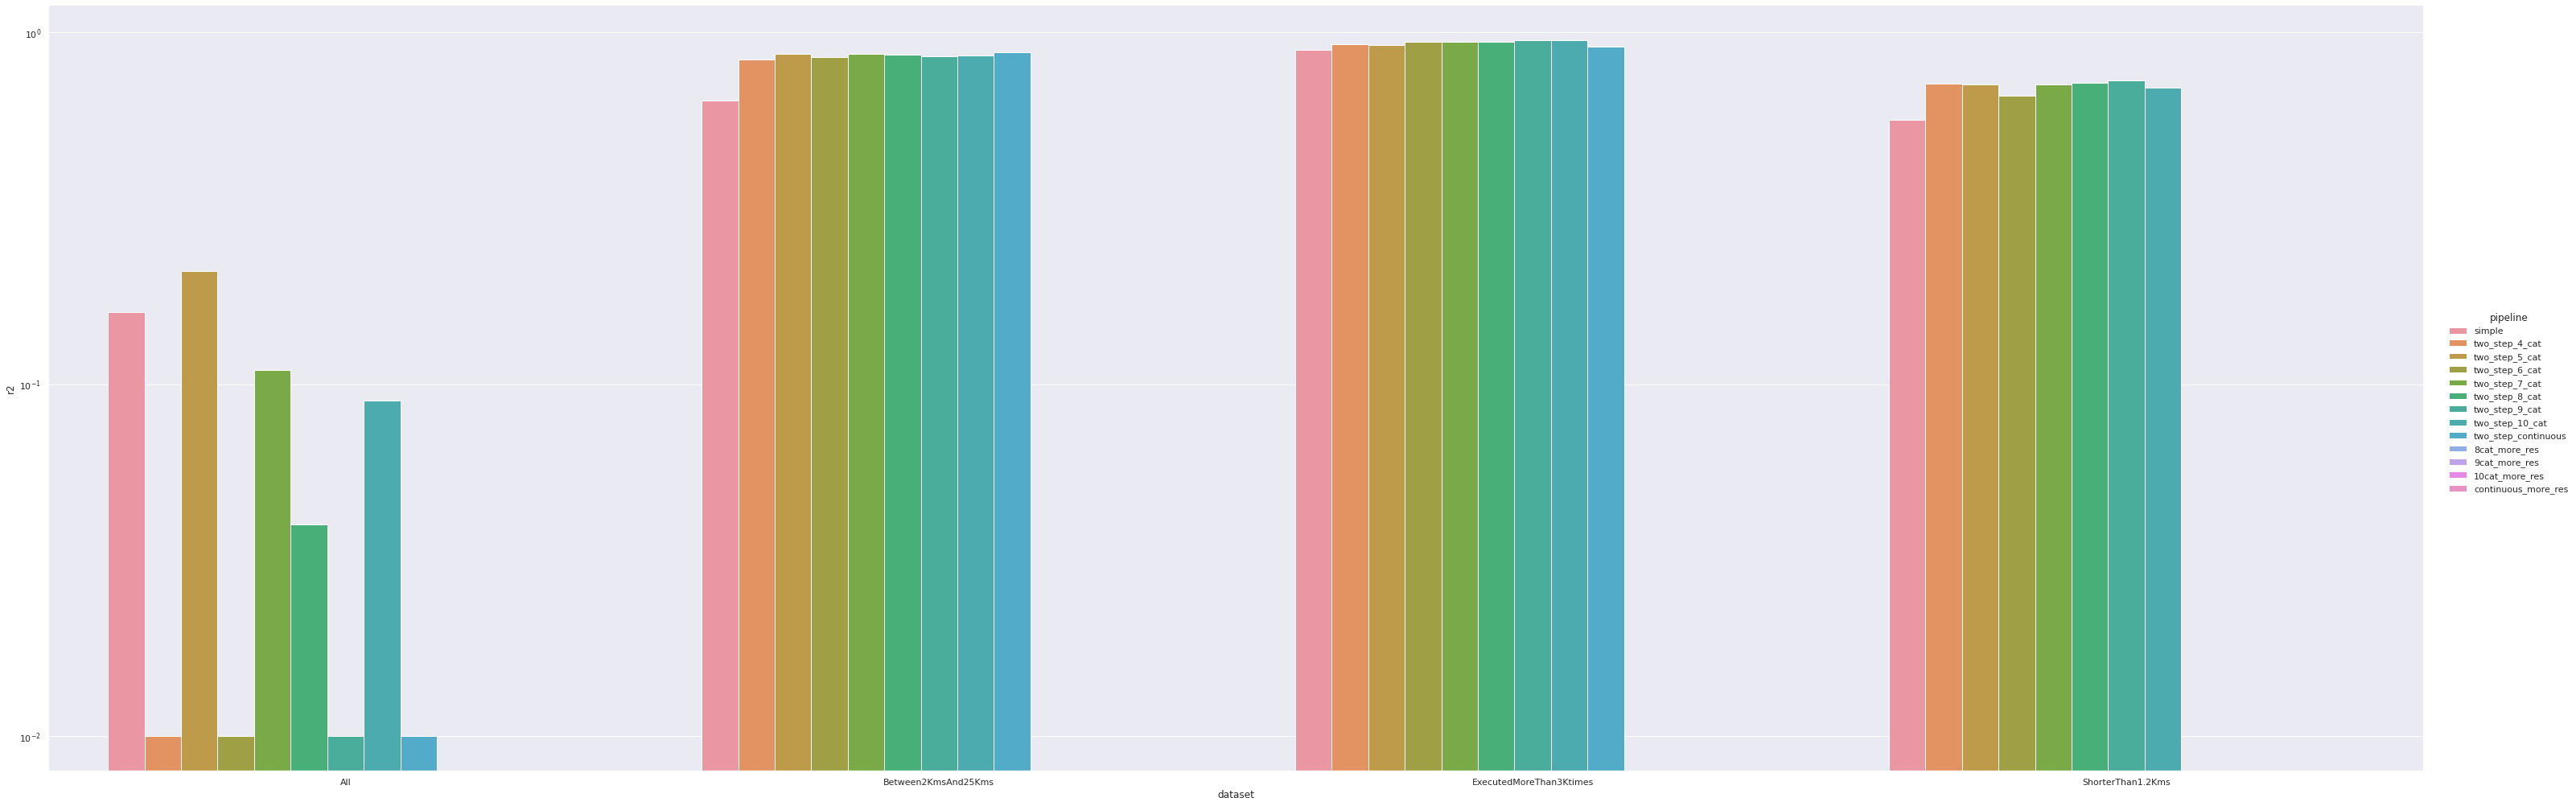

In [401]:
bar(errors_df(exp1_df, "r2"), "dataset", "r2", "pipeline", pipeline_order)

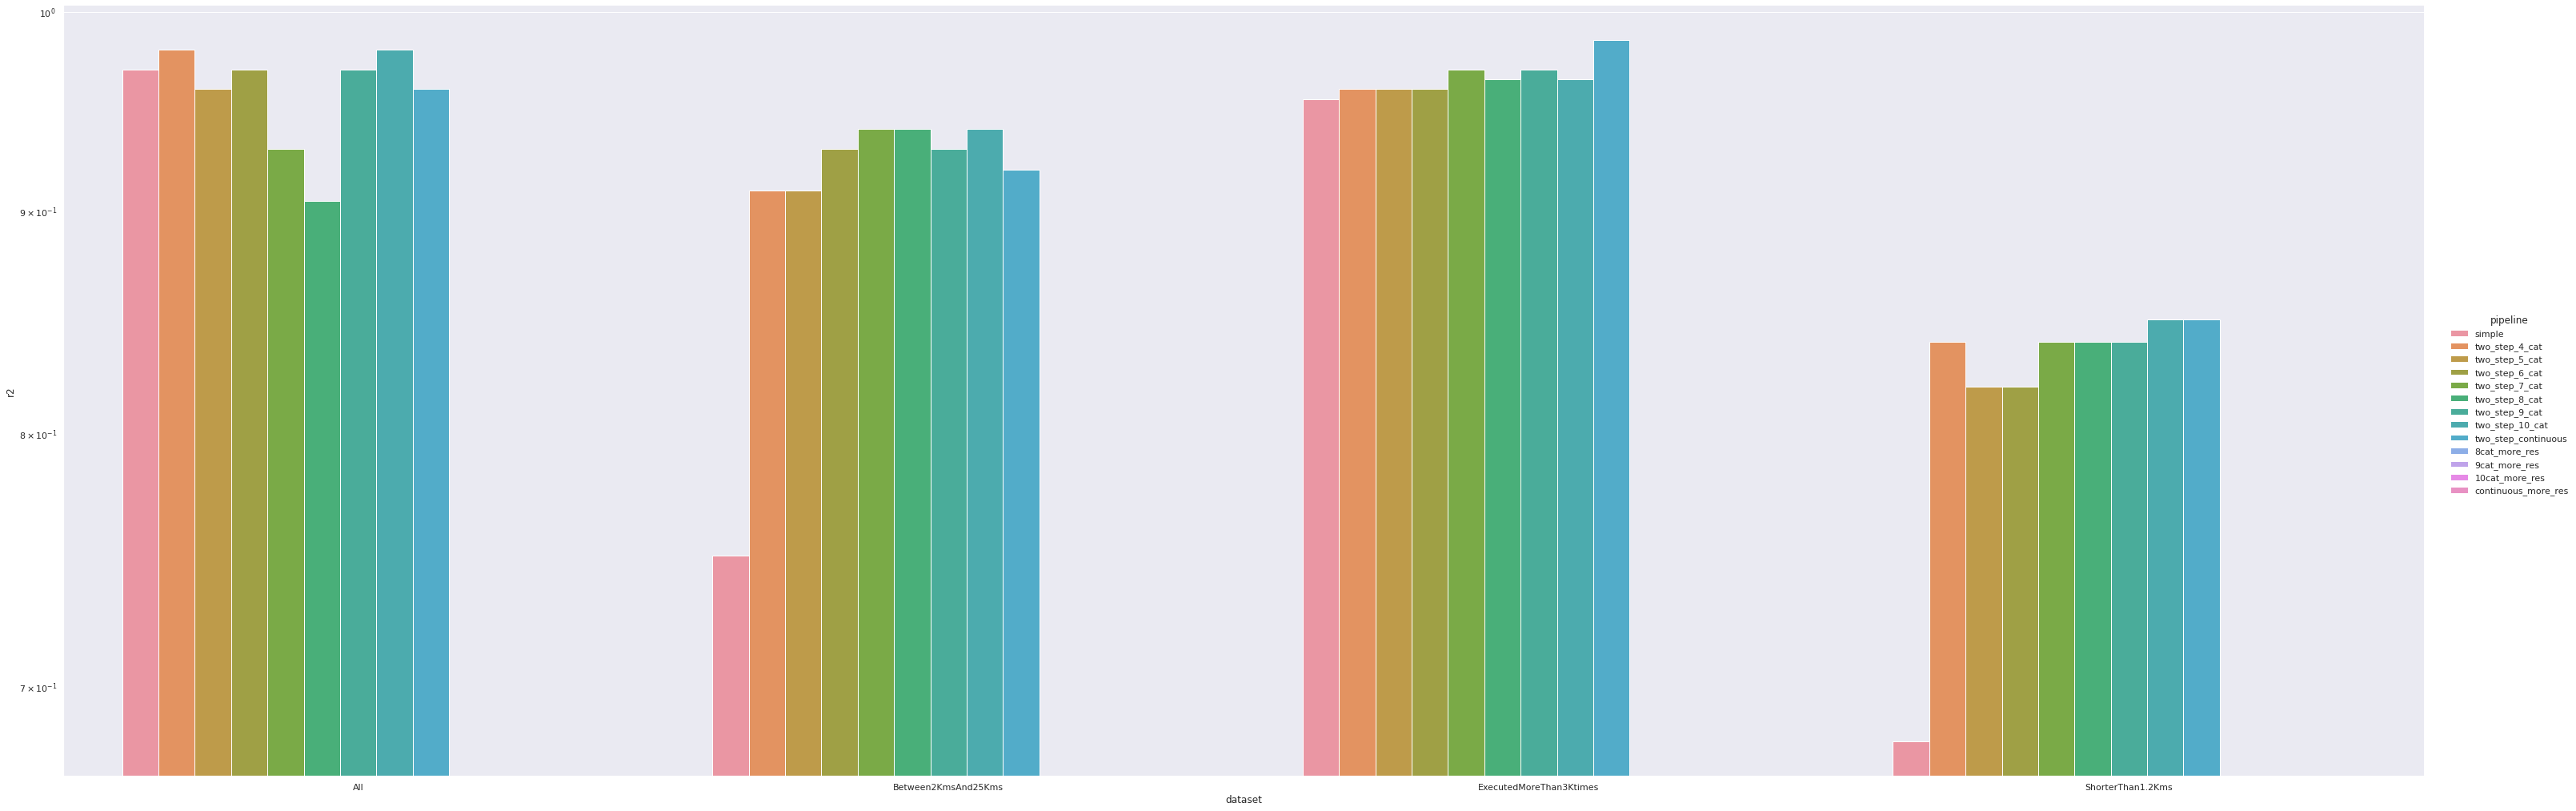

In [402]:
bar(errors_df(exp1_df, "r2", lambda df: df.idxmax()), "dataset", "r2", "pipeline", pipeline_order)

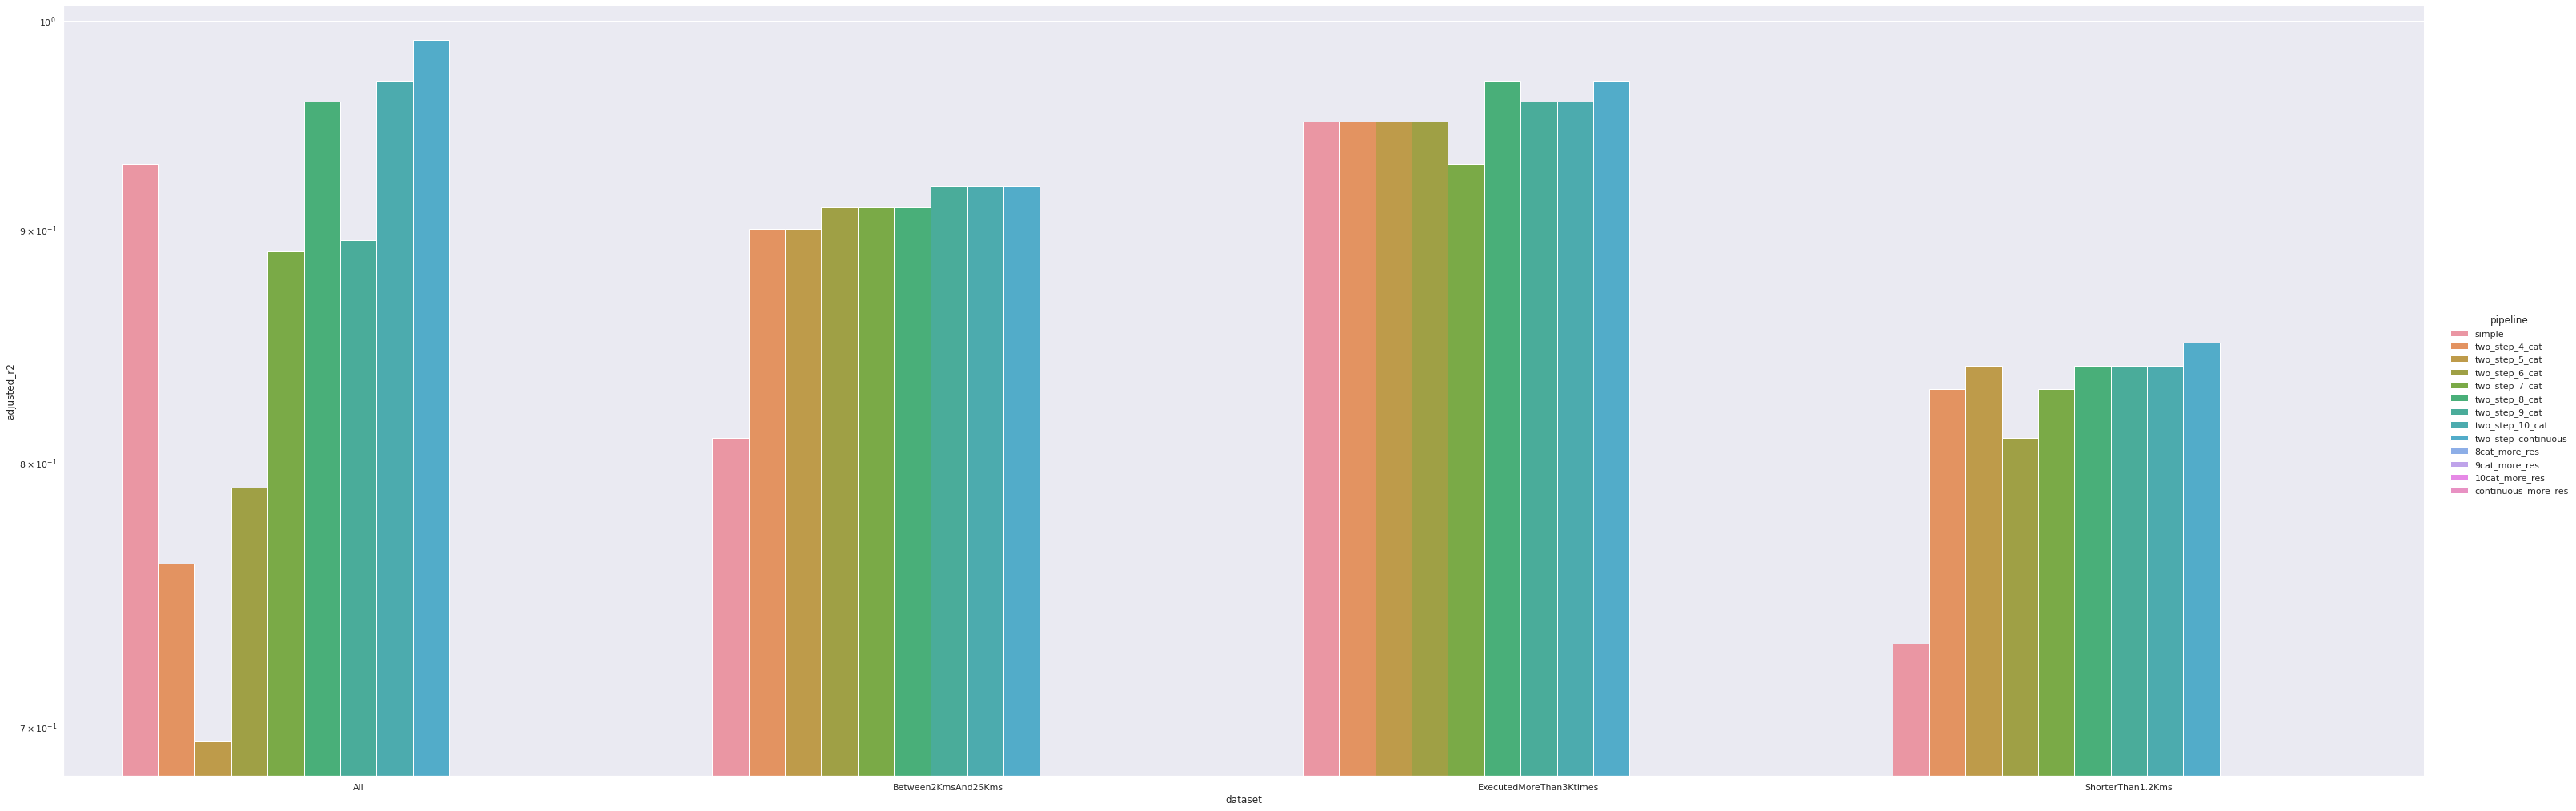

In [42]:
bar(errors_df(exp1_df, "adjusted_r2", lambda df: df.idxmax()), "dataset", "adjusted_r2", "pipeline", pipeline_order)

In [43]:
# exp1_df.iloc[exp1_df.groupby("dataset")["r2"].idxmax()]
# exp1_df.iloc[exp1_df.groupby("dataset")["mape"].idxmax()]
# exp1_df[exp1_df["dataset"] =="All"].sort_values("r2", ascending=False)

#### Odpowiedzi

odpowiedzi: czy I, czy II, czy dzielić na więcej niż 4 kategorie